## Packages

In [1]:
import sys, os
import numpy as np 
import xarray as xr
import netCDF4 as nc
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

/Users/leguillou/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
myPath = '/Users/leguillou/WORK/Developpement/'
sys.path.insert(0,myPath+'BOOST-SWOT/codes/dev/swotda/models/model_qgsw')
import qgsw as qg
sys.path.insert(0,myPath+'toolbox')
from PowerSpec import *

In [3]:
dir_data =  myPath + "DATA/eNATL60/daily_outputs/"
filename_data = "eNATL60_noTides_GULFSTREAM_SSHdegraded-1-30.1d_y2009m10d01_y2009m12d31.nc"


name_study =  'QG_forecast_timeHorizons_init-eNATL60_noTides'
dir_output = myPath + 'experiences/outputs/' + name_study + '/'
if os.path.exists(dir_output) is False:
    os.makedirs(dir_output)
filename_output = 'QG_forecast_eNATL60_noTides_GULFSTREAM_SSHdegraded-1-30.nc'

dir_plots = myPath+'experiences/plots/' + name_study + '/'
if os.path.exists(dir_plots) is False:
    os.makedirs(dir_plots)

## Read eNATL60 data

In [4]:
xrin = xr.open_mfdataset(dir_data + filename_data)
print(xrin)

<xarray.Dataset>
Dimensions:       (time: 92, x: 240, y: 240)
Coordinates:
  * time          (time) datetime64[ns] 2009-10-01T00:32:00 ... 2009-12-31T00:29:52
Dimensions without coordinates: x, y
Data variables:
    lon           (y, x) float32 dask.array<shape=(240, 240), chunksize=(240, 240)>
    lat           (y, x) float32 dask.array<shape=(240, 240), chunksize=(240, 240)>
    ssh_degraded  (time, y, x) float32 dask.array<shape=(92, 240, 240), chunksize=(92, 240, 240)>


In [5]:
SSH_true = xrin['ssh_degraded'].values 
timestamps = xrin['time'].values
navlat = xrin['lat'].values
navlon = xrin['lon'].values

In [6]:
mean_field = np.nanmean(np.nanmean(SSH_true,axis=2),axis=1)

In [7]:
SSH_true = SSH_true - mean_field[:,np.newaxis,np.newaxis]

## Get initialisation listes

In [8]:
timestep = np.timedelta64(1,'D') # 1 day
dt = timestamps[1] - timestamps[0]
pas = int(timestep / dt)

In [9]:
nb_runs = 30 

In [11]:
SSH_true_init = SSH_true[:pas*nb_runs:pas,:,:]
timestamps_init = timestamps[:pas*nb_runs:pas]

## QG forecasts

In [12]:
th_max = 10 # temporal horizon in days

In [13]:
SSH_true_all = []  # list gathering true SSH per temporal horizons for each forecast day
SSH_qg_all = []
for t in range(nb_runs):
    print(t+1,'/',nb_runs)
    SSH_i = SSH_true_init[t]
    ts_i = timestamps_init[t]
    SSH_true_all.append(SSH_true[pas*t:pas*(th_max+t+1):pas])
    SSH_qg, _, _ = qg.qgsw(Hi=SSH_i,c=2.7+SSH_i*0,lon=navlon,lat=navlat,tint=th_max*24*3600,dtout=24*3600,dt=200,name_grd=myPath + 'DATA/grid/grid_gulfstream_regular')    
    if np.any([np.all(np.isnan(ssh)) for ssh in SSH_qg]):
        print('Warning: QG crashed!')
    SSH_qg_all.append(SSH_qg)

1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


#### Convert to numpy arrays

In [14]:
SSH_true_all = np.asarray(SSH_true_all)
SSH_qg_all = np.asarray(SSH_qg_all)

#### Save to netcdf 

In [15]:
NY,NX = navlat.shape
ncout = nc.Dataset(dir_output + filename_output, 'w', format='NETCDF3_CLASSIC')
ncout.createDimension('nb_runs', nb_runs)
ncout.createDimension('nb_horizons', th_max+1)
ncout.createDimension('x', NX)
ncout.createDimension('y', NY)
ncth = ncout.createVariable('time_horizons', 'f', ('nb_horizons',))  
ncref = ncout.createVariable('SSH_ref', 'f', ('nb_runs','nb_horizons','y','x',))  
ncqg = ncout.createVariable('SSH_QG', 'f', ('nb_runs','nb_horizons','y','x',))
ncth.units = "days"
ncth[:] = range(0,th_max+1)
ncref[:,:,:,:] = SSH_true_all
ncqg[:,:,:,:] = SSH_qg_all
ncout.close()

## Compute spectrum

#### Open netcdf file

In [16]:
ncin = nc.Dataset(dir_output + filename_output)
SSH_true_all = ncin.variables['SSH_ref'][:,:,:,:]
SSH_qg_all = ncin.variables['SSH_QG'][:,:,:,:]
time_horizons = ncin.variables['time_horizons'][:]
nb_runs = SSH_true_all.shape[0]

In [17]:
psd2D_ref = []
psd2D_qg = []
for th in range(len(time_horizons)):
    psd2D_qg_th = []
    for i in range(nb_runs):
        if th==0:
            wavenumber,psd2D_ref_i = wavenumber_spectra(np.ma.array(SSH_true_all[i,th]),navlon,navlat) 
            psd2D_ref.append(psd2D_ref_i)
        wavenumber,psd2D_qg_th_i = wavenumber_spectra(np.ma.array(SSH_qg_all[i,th]),navlon,navlat)
        psd2D_qg_th.append(psd2D_qg_th_i)
    psd2D_qg.append(np.mean(psd2D_qg_th,axis=0))
psd2D_ref = np.mean(psd2D_ref,axis=0)
wavenumber *= 1e3 # in cycle/km    

## Plots

In [18]:
linewidth = 3
cm = plt.get_cmap('CMRmap') 
colors=[cm(i/len(time_horizons)) for i in range(len(time_horizons))]

In [1]:
for th in range(1,len(time_horizons)):
    fig = plt.figure(figsize=(30,15))
    ax1 = plt.subplot(1,1,1)  # wavenumber
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.plot(wavenumber,psd2D_ref,'k',linewidth=linewidth,label='eNATL60',linestyle='--')
    ax1.plot(wavenumber,psd2D_qg[th],c=colors[th],linewidth=linewidth,label='QG '+'th='+str(th)+' days')
    ax1.tick_params(axis="x", labelsize=15)
    ax1.tick_params(axis="y", labelsize=15)
    ax1.grid(True,which="both",ls="--")
    ax1.set_xlim(.002,0.1)
    ax1.set_ylim(1e-6,2000)
    ax1.legend(fontsize=30)
    ax1.set_xlabel('wavenumber (cpkm)',fontsize=20)
    ax1.set_ylabel('2D Power Spectra Density',fontsize=20)
    fig.savefig(dir_plots + 'PSD_th-' + str(th))
 

    

NameError: name 'time_horizons' is not defined

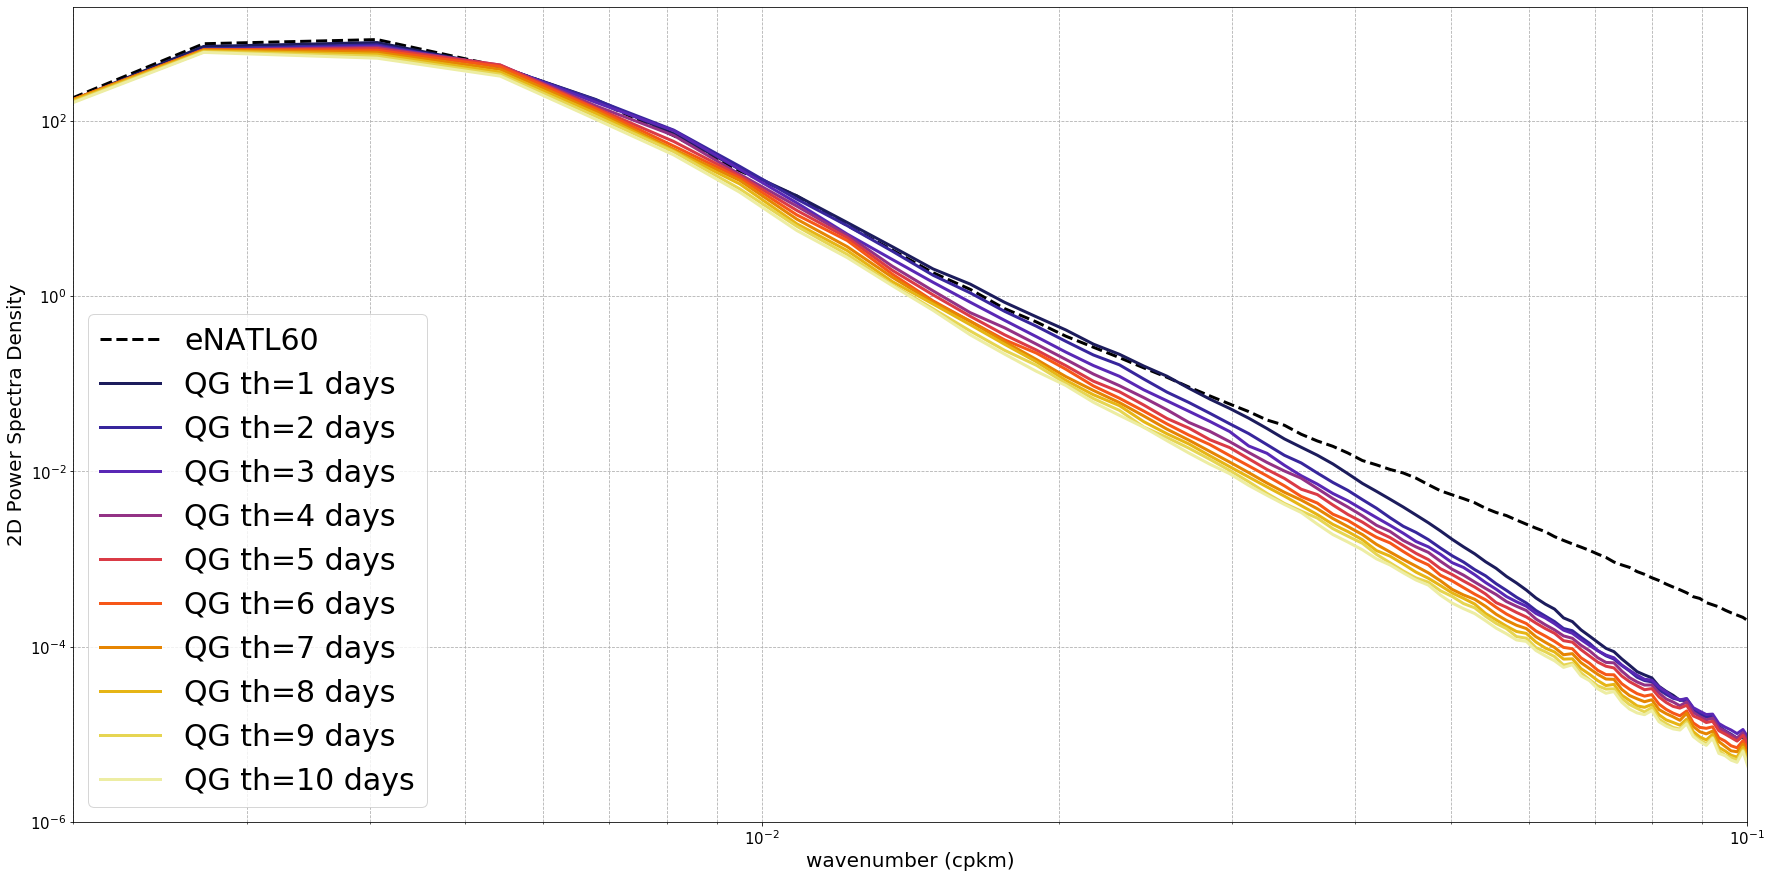

In [20]:
fig = plt.figure(figsize=(30,15))
ax1 = plt.subplot(1,1,1)  # wavenumber
ax1.plot(wavenumber,psd2D_ref,'k',linewidth=linewidth,label='eNATL60',linestyle='--')
for th in range(1,len(time_horizons)):    
    ax1.plot(wavenumber,psd2D_qg[th],c=colors[th],linewidth=linewidth,label='QG '+'th='+str(th)+' days')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)
ax1.grid(True,which="both",ls="--")
ax1.set_xlim(.002,0.1)
ax1.set_ylim(1e-6,2000)
ax1.legend(fontsize=30)
ax1.set_xlabel('wavenumber (cpkm)',fontsize=20)
ax1.set_ylabel('2D Power Spectra Density',fontsize=20)
fig.savefig(dir_plots + 'PSD_th-all')